<a href="https://colab.research.google.com/github/richeung1/Fake-News-Detector/blob/main/Fake_News_Detector_26Jul2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Fake News Detector***



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing Python Packages

# Pandas and Numpy for working with dataframe/arrays
import pandas as pd
import numpy as np

# Matplotlib, Seaborn, and WordCloud for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLTK for tokenization (splitting sentences into single words)
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# TfidfVectorizer for changing words into numerical data (necessary for machine learning models)
from sklearn.feature_extraction.text import TfidfVectorizer

# Train Test Split to split up the data into a training set (data that model uses for training) and a test set (unseen data that model uses for predictions)
from sklearn.model_selection import train_test_split

# 3 different machine learning models (each model uses different math/statistics): Logistic Regression, K-Nearest Neighbors, and Random Forest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Accuracy score as a metric to compare machine learning model's predictions from the unseen test set vs the unseen test set's actual data
from sklearn import metrics
from sklearn.metrics import accuracy_score

# GridSearchCV to finetune the model's hyperparameters (each model comes with extra settings that can be adjusted to achieve better accuracy)
from sklearn.model_selection import GridSearchCV


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Loading data: news_articles.csv. Then doing exploratory data analysis (EDA) and any required data clean up.**

In [3]:
# Loading news_articles.csv into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Colab Notebooks/Fake vs Real News/Fake vs Real News First Trial/news_articles.csv')

In [4]:
df.head(5)

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


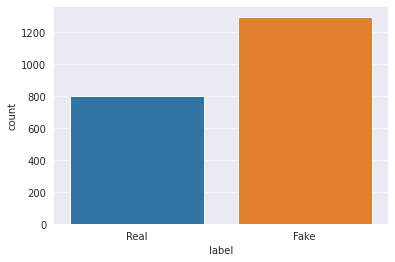

In [5]:
# Dataset is not balanced.
sns.set_style("darkgrid")
sns.countplot(df.label)

In [6]:
# Shows we have 2,096 rows by 12 columns
df.shape

(2096, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2096 non-null   object 
 1   published                2096 non-null   object 
 2   title                    2096 non-null   object 
 3   text                     2050 non-null   object 
 4   language                 2095 non-null   object 
 5   site_url                 2095 non-null   object 
 6   main_img_url             2095 non-null   object 
 7   type                     2095 non-null   object 
 8   label                    2095 non-null   object 
 9   title_without_stopwords  2094 non-null   object 
 10  text_without_stopwords   2046 non-null   object 
 11  hasImage                 2095 non-null   float64
dtypes: float64(1), object(11)
memory usage: 196.6+ KB


In [8]:
# Shows we have N/A or NaN values in various columns such as text, label, etc. Machine Learning models have issues with N/A or NaN values since these are missing values.
df.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

In [9]:
# Creating a new dataframe with only the columns that I want: text_without_stopwords (text of the news articles without filler/useless words such as "like", "and", etc.). In simple terms this column is the X variable.
new_df = pd.DataFrame(df['text_without_stopwords'])

In [10]:
# Second column of the new dataframe is: labels because ultimately this is what we want to predict: Real vs. Fake. This column is basicaly the Y variable.
new_df['labels'] = df['label']

In [11]:
# Deciding to drop the N/A and NaN values from the new dataframe so all rows/columns no longer have missing values.
new_df = new_df.dropna()

In [12]:
new_df.head(5)

,text_without_stopwords,labels
0,print pay back money plus interest entire fami...,Real
1,attorney general loretta lynch plead fifth bar...,Real
2,red state fox news sunday reported morning ant...,Real
3,email kayla mueller prisoner tortured isis cha...,Real
4,email healthcare reform make america great sin...,Real


In [13]:
# Changing the values of the labels column into numbers. Machine Learning models often work best with numerical data.
new_df['labels'] = new_df['labels'].map({'Real': 1, 'Fake': 0})

In [14]:
new_df.head(5)

,text_without_stopwords,labels
0,print pay back money plus interest entire fami...,1
1,attorney general loretta lynch plead fifth bar...,1
2,red state fox news sunday reported morning ant...,1
3,email kayla mueller prisoner tortured isis cha...,1
4,email healthcare reform make america great sin...,1


In [15]:
new_df.shape

(2046, 2)

**Word Tokenization: turning each news article's sentences into individual words. Individual words are the building blocks of language so this transformation is necessary for natural language processing (NLP) tasks which is what we are doing.**

In [16]:
new_df['text_without_stopwords'] = new_df['text_without_stopwords'].apply(lambda x: word_tokenize(str(x)))

In [17]:
# News articles in text_without_stopwords colulmn has been transformed into individual words separted by a comma.
new_df.head(5)

,text_without_stopwords,labels
0,"[print, pay, back, money, plus, interest, enti...",1
1,"[attorney, general, loretta, lynch, plead, fif...",1
2,"[red, state, fox, news, sunday, reported, morn...",1
3,"[email, kayla, mueller, prisoner, tortured, is...",1
4,"[email, healthcare, reform, make, america, gre...",1


In [18]:
# Creating word cloud to see visually what the most common words are in the Real vs Fake categories
new_df_fake = new_df.loc[new_df['labels'] == 0, ['text_without_stopwords']]
new_df_real = new_df.loc[new_df['labels'] == 1, ['text_without_stopwords']]

def plot_cloud(wordcloud):
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off")

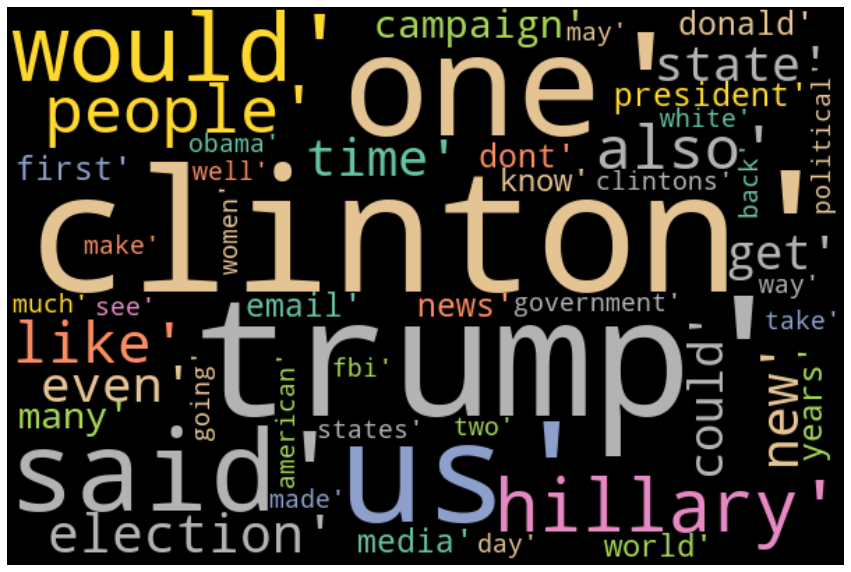

In [19]:
# Showing what most common words are in the Fake news category
wordcloudfake = WordCloud(width = 600, height = 400, random_state=1, background_color='black', colormap='Set2', collocations=False, max_words=50).generate_from_text(','.join(str(v) for v in new_df_fake['text_without_stopwords']))
plot_cloud(wordcloudfake)

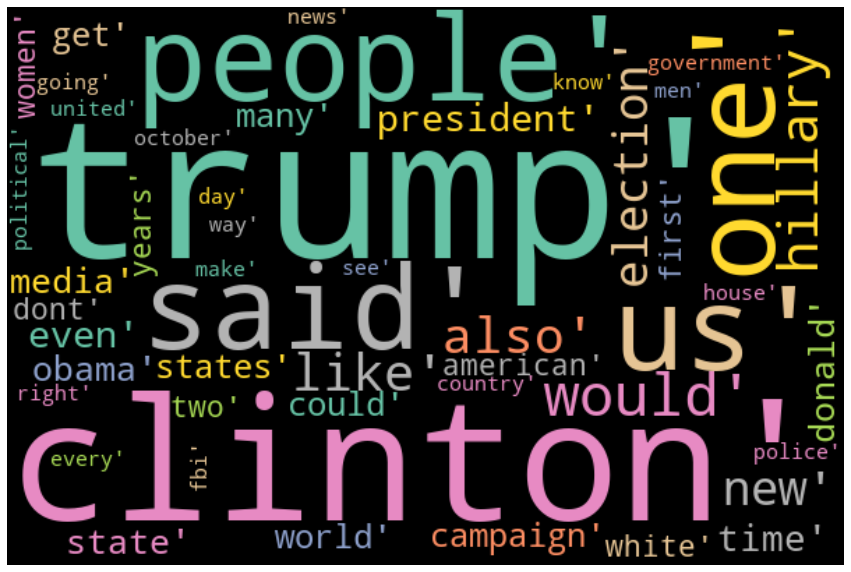

In [20]:
# Showing what most common words are in the Real news category
wordcloudreal = WordCloud(width = 600, height = 400, random_state=1, background_color='black', colormap='Set2', collocations=False, max_words=50).generate_from_text(','.join(str(v) for v in new_df_real['text_without_stopwords']))
plot_cloud(wordcloudreal)

{"'clinton',": 2013, "'trump',": 1943, "'one',": 1420, "'said',": 1363, "'us',": 1360, "'would',": 1351, "'hillary',": 1279, "'people',": 1268, "'also',": 1084, "'like',": 981, "'election',": 889, "'new',": 864, "'time',": 847, "'even',": 806, "'state',": 746, "'could',": 721, "'get',": 704, "'campaign',": 684, "'many',": 647, "'president',": 633}


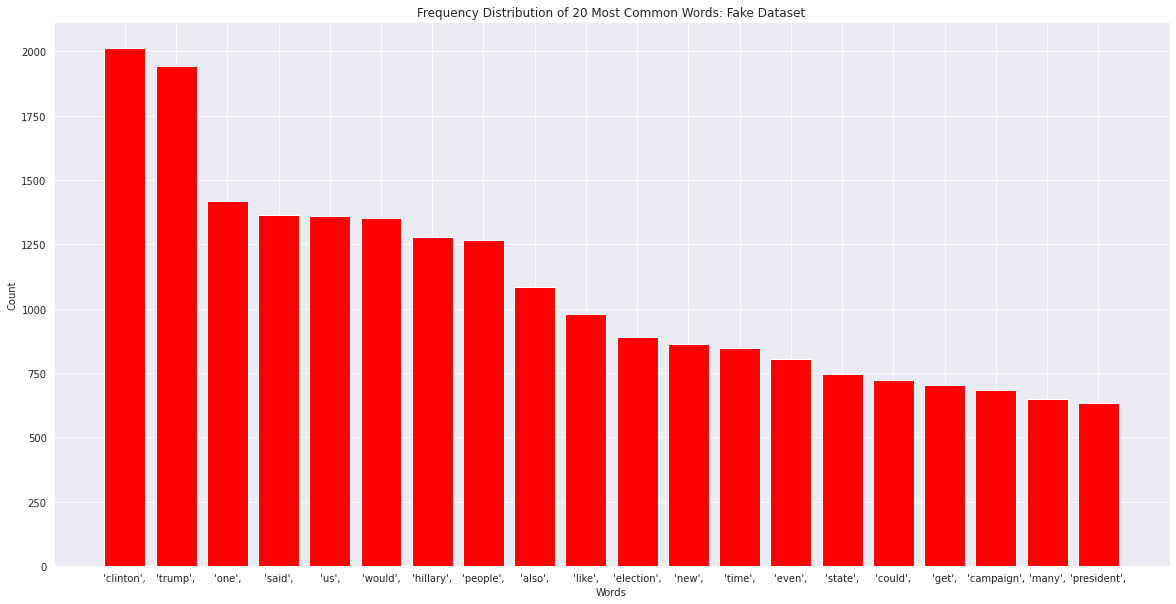

In [21]:
# Word frequency distribution for fake news
corpus = []
for document in new_df_fake['text_without_stopwords']:
  document = list(str(document).split(' '))
  for word in document:
            corpus.append(word)

%matplotlib inline
fd = nltk.FreqDist(corpus)
freq_W = fd.most_common(20)

def Convert(tup, di):
    di = dict(tup)
    return di
      
di = {}
freq_dict = Convert(freq_W, di)

print(freq_dict)

fig = plt.figure(figsize=(20,10))
plt.title("Frequency Distribution of 20 Most Common Words: Fake Dataset")
plt.xlabel("Words")
plt.ylabel("Count")
plt.bar(freq_dict.keys(), freq_dict.values(), color='r')
plt.savefig("freq dist.png", dpi=300)
plt.show(fig)


{"'trump',": 1408, "'clinton',": 1025, "'people',": 991, "'us',": 973, "'said',": 959, "'one',": 945, "'would',": 859, "'hillary',": 740, "'like',": 668, "'also',": 647, "'new',": 568, "'even',": 554, "'president',": 549, "'election',": 549, "'time',": 527, "'state',": 490, "'obama',": 489, "'donald',": 473, "'media',": 464, "'campaign',": 449}


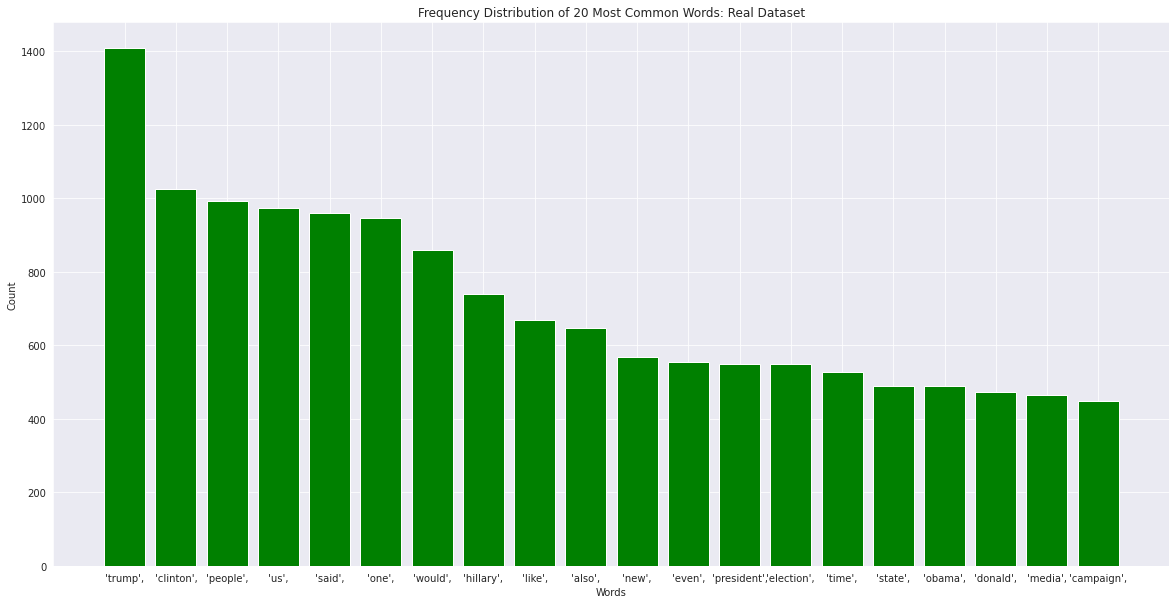

In [22]:
# Word frequency distribution for real news
corpus = []
for document in new_df_real['text_without_stopwords']:
  document = list(str(document).split(' '))
  for word in document:
            corpus.append(word)

%matplotlib inline
fd = nltk.FreqDist(corpus)
freq_W = fd.most_common(20)

def Convert(tup, di):
    di = dict(tup)
    return di
      
di = {}
freq_dict = Convert(freq_W, di)

print(freq_dict)

fig = plt.figure(figsize=(20,10))
plt.title("Frequency Distribution of 20 Most Common Words: Real Dataset")
plt.xlabel("Words")
plt.ylabel("Count")
plt.bar(freq_dict.keys(), freq_dict.values(), color='g')
plt.savefig("freq dist.png", dpi=300)
plt.show(fig)

**Vectorizing: transforming tokens (individual words) into numerical data. This is necessary since machine learning models use math/statistics to find patterns in data.**

In [23]:
Vectorizer = TfidfVectorizer()

In [24]:
X = Vectorizer.fit_transform(new_df['text_without_stopwords'].astype(str))
y = new_df['labels'].values

**Train Test Split to split up the data into a training set (data that model uses for training) and a test set (unseen data that model uses for predictions).**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33, 
    stratify=y
)

**Training Logistic Regression model.**

In [26]:
# Logistic Regression

clf = LogisticRegression(max_iter = 5000)

In [27]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [28]:
# Initial accuracy score from Logistic Regression ~69%
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.6863905325443787


**Training K-Nearest Neighbors model.**

In [29]:
# KNNeighbors

klf = KNeighborsClassifier(n_neighbors = 5)

In [30]:
klf.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
yk_pred = klf.predict(X_test)

In [32]:
# Initial accuracy score from K-Nearest Neighbors ~67%
print(accuracy_score(y_test, yk_pred))

0.6686390532544378


**Training Random Forest model.**

In [33]:
# Random Forest

rlf = RandomForestClassifier()

In [34]:
rlf.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
yr_pred = rlf.predict(X_test)

In [36]:
# Initial accuracy score from Random Forest ~74%
print(accuracy_score(y_test, yr_pred))

0.7440828402366864


**Fine Tuning: adjusting machine learning model's settings i.e. parameters to improve accuracy. GridSearchCV takes in the model and various arguments to perform the trainings and predictions again with the parameters that you choose.**

##### **Fine Tuning Logistic Regression model.**

In [37]:
# # GridSearchCV on Logistic Regression: using different parameters
penalty1 = ['l1']
solver1 = ['liblinear', 'saga']

penalty2 = ['l2']
solver2 = ['lbfgs', 'newton-cg', 'sag']

C = np.logspace(-3,3,7)

params1 = dict(penalty = penalty1,
               C = C,
               solver = solver1)

params2 = dict(penalty = penalty2,
               C = C,
               solver = solver2)

LR1 = GridSearchCV(clf, param_grid= params1, cv=3, verbose=1, n_jobs=-1)
LR2 = GridSearchCV(clf, param_grid= params2, cv=3, verbose=1, n_jobs=-1)

In [38]:
LR1GridSearch = LR1.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [39]:
LR2GridSearch = LR2.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


In [40]:
LR1GridSearch.best_params_

{'C': 100.0, 'penalty': 'l1', 'solver': 'saga'}

In [41]:
# Best parameters for Logistic Regression based on next 2 rows: LR2GridSearch.best_score_
LR2GridSearch.best_params_

{'C': 1000.0, 'penalty': 'l2', 'solver': 'lbfgs'}

In [42]:
LR1GridSearch.best_score_

0.7394093823179393

In [43]:
LR2GridSearch.best_score_

0.7328304349495184

In [46]:
# Predicting on Logistic Regression's best parameters. We will get 78% accuracy which is higher than our intial result of 69%.
LRL1Model = LR1GridSearch.best_estimator_
LRL1_Pred = LRL1Model.predict(X_test)
print(accuracy_score(y_test, LRL1_Pred))

0.7810650887573964


#### **Fine Tuning K-Nearest Neighbors Model**

In [47]:
# GridSearchCV on KNNeighbors: using different parameters
n_neighbors = [5,7,10,15]
weights = ['uniform','distance']
leaf_size = [5,10,30,50]
p = [1,2]
n_jobs = [-1]

params = dict(n_neighbors = n_neighbors,
              weights = weights,
              leaf_size = leaf_size,
              p = p,
              n_jobs = n_jobs)

glf = GridSearchCV(klf, params, cv=5, verbose=1, n_jobs=-1)

In [48]:
KNNGridSearch = glf.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [49]:
# Best parameters for KNNeighbors
KNNGridSearch.best_params_

{'leaf_size': 5,
 'n_jobs': -1,
 'n_neighbors': 15,
 'p': 2,
 'weights': 'distance'}

In [50]:
KNNGridSearch.best_score_

0.7138686131386862

In [51]:
# Predicting on K-Nearest Neighbor's best parameters. We will get 67% accuracy which is the same as our initial result.
KNNModel = KNNGridSearch.best_estimator_
KNNPred = KNNModel.predict(X_test)
print(accuracy_score(y_test, KNNPred))

0.6671597633136095


#### **Fine Tuning Random Forest Model.**

In [52]:
# GridSearchCV on Random Forest: using different parameters

n_estimators = [50, 75, 100]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [4, 5, 6, 7, 8]
criterion = ['gini', 'entropy']

params = dict(n_estimators = n_estimators,
              max_features = max_features,
              max_depth = max_depth,
              criterion = criterion)

RFGridSearch = GridSearchCV(rlf, params, cv=5, verbose=1, n_jobs=-1)

In [53]:
RFGridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 75, 100]},
             verbose=1)

In [54]:
# Best parameters for Random Forest

RFGridSearch.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [57]:
RFGridSearch.best_score_

0.6467153284671533

In [58]:
# Predicting on Random Forest's best parameters. We will get ~64% vs intial result of 74%. The Random Forest's default parameters were better.
RFModel = RFGridSearch.best_estimator_
RFPred = RFModel.predict(X_test)
print(accuracy_score(y_test, RFPred))

0.6390532544378699


**After GridSearchCV we see that the optimized Logistic Regression model gave us the highest accuracy score ~74%. Now I want to dig deeper into this metric by using a confusion matrix. This will help to show true positives, false positives, true negatives, and false negatives. Perhaps the model was more accurate towards Real news instead of Fake news or vice versa.**

In [59]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

In [60]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Fake', 'Real'])

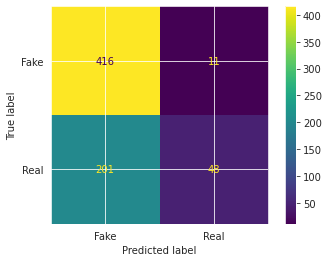

In [61]:
cm_display.plot()
plt.show()